# MultiModal RAG!

### This notebook demonstrates the creation of a Multimodal Retrieval-Augmented Generation (RAG) setup, with the specific example of fashion styling, leveraging various state-of-the-art technologies and datasets.

Inspired by ChromaDB's [recent announcement](https://docs.trychroma.com/guides/multimodal) of integration with CLIP embeddings, and interest in both testing multimodal embedding and their integration into RAG techniques with models that can take both text and image input, I put together this project to provide a comprehensive outline of context and application multimodal RAG

![x](clip.drawio.png)

---
## Dependencies

Importing all the packages we'll need to support this project

In [14]:
import os
import chromadb
import base64
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
from chromadb.utils.data_loaders import ImageLoader
from IPython.display import Image, display, Markdown
from datasets import load_dataset
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

---
## Loading the Dataset

Going to be using the [Fashionpedia dataset](https://huggingface.co/datasets/detection-datasets/fashionpedia) through HuggingFace, originally created as an object detection training dataset.

**Description from their website:**

*Fashionpedia is a dataset which consists of two parts: (1) an ontology built by fashion experts containing 27 main apparel categories, 19 apparel parts, 294 fine-grained attributes and their relationships; (2) a dataset with 48k everyday and celebrity event fashion images annotated with segmentation masks and their associated per-mask fine-grained attributes, built upon the Fashionpedia ontology.*

Used originally for classification and localized attribution of objects in fashion images, the model architecture the fashionpedia team made:

<img src="fashionpedia.png" alt="Fashionpedia Model" width="1000">


You can check out their [popular paper here](https://paperswithcode.com/paper/fashionpedia-ontology-segmentation-and-an), and their [website with more details here](https://fashionpedia.github.io/home/index.html)!

We'll use the HF datasets package to load and prepare the data:

In [2]:
dataset = load_dataset("detection-datasets/fashionpedia")

Generating train split:   0%|          | 0/45623 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/1158 [00:00<?, ? examples/s]

#### Sample Image

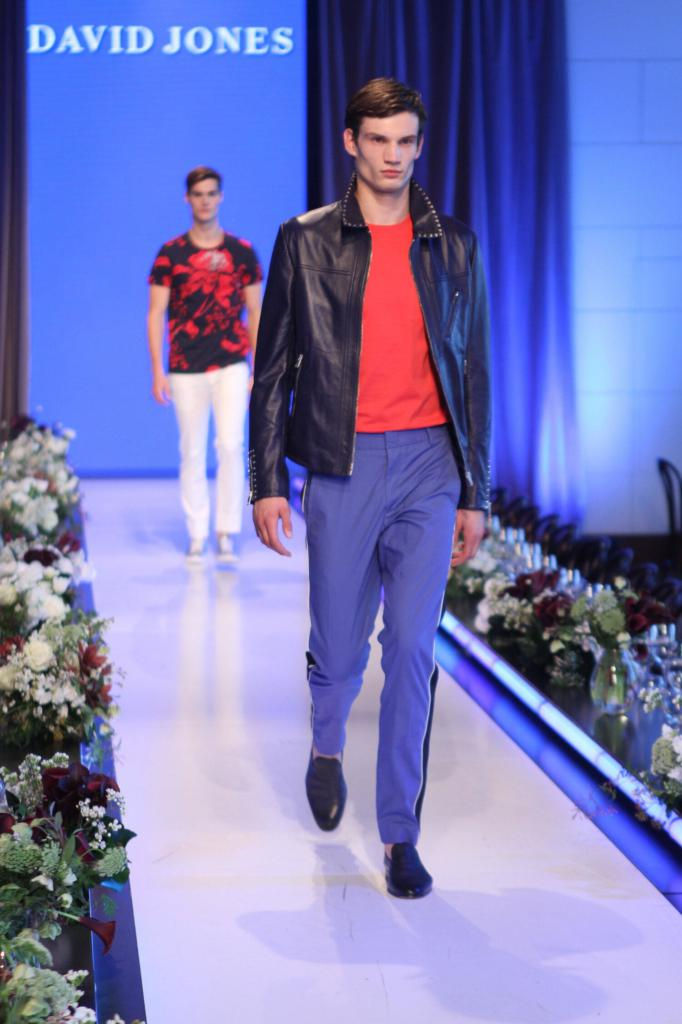

In [3]:
dataset['train'][3]['image']

### Saving the Photos for Our Use

For this example, we'll grab the first 1000 photos and save them locally to make it easier to load into our Vector Database

In [4]:
# Define the folder to save the images
dataset_folder = '/Users/alucek/Documents/Jupyter_Notebooks/image_rag/fashion_dataset'
os.makedirs(dataset_folder, exist_ok=True)

# Function to save images
def save_images(dataset, dataset_folder, num_images=1000):
    for i in range(num_images):
        # Get the image data
        image = dataset['train'][i]['image']
        
        # Save the image
        image.save(os.path.join(dataset_folder, f'image_{i+1}.png'))

# Save the first 1000 images
save_images(dataset, dataset_folder, num_images=1000)

print(f"Saved the first 1000 images to {dataset_folder}")

Saved the first 1000 images to /Users/alucek/Documents/Jupyter_Notebooks/image_rag/fashion_dataset


---
# Setting Up the Vector Database

We'll be using the open-source vector database [ChromaDB](https://www.trychroma.com/), which recently announced its support for multimodal embeddings!

ChromaDB has integrated with OpenCLIP embedding models. [CLIP](https://openai.com/index/clip/) (Contrastive Language-Image Pre-training) was originally developed by OpenAI and has since been replicated and open-sourced through the [OpenCLIP effort](https://github.com/mlfoundations/open_clip). CLIP leverages text-image pairs from the internet, allowing the model to understand and classify images in a zero-shot manner. This means it can perform tasks without being specifically trained on them.

ChromaDB's OpenCLIP integration currently uses the [CLIP-ViT-B-32-laion2B-s34B-b79K](https://huggingface.co/laion/CLIP-ViT-B-32-laion2B-s34B-b79K) embedding model, which is described as follows:

*A CLIP ViT-B/32 model trained with the LAION-2B English subset of [LAION-5B](https://laion.ai/blog/laion-5b/) using [OpenCLIP](https://github.com/mlfoundations/open_clip). Model training was done by Romain Beaumont on the stability.ai cluster.*

[LAION-5B](https://laion.ai/blog/laion-5b/) is a large-scale, open dataset containing 5.85 billion CLIP-filtered image-text pairs. It aims to democratize research and experimentation in training large-scale multimodal models like CLIP, DALL-E, and others. "CLIP-filtered" refers to the process of using OpenAI's CLIP model to select high-quality image-text pairs from a larger dataset. Since CLIP is trained to understand images and their corresponding textual descriptions, using it to filter data ensures that the LAION-5B image-text pairs are relevant and accurately matched, improving the quality of data for training and evaluating AI models.

In [5]:
# Instantiate the ChromaDB CLient
chroma_client = chromadb.PersistentClient(path="/Users/alucek/Documents/Jupyter_Notebooks/image_rag/image_vdb")
# Instantiate the ChromaDB Image Loader
image_loader = ImageLoader()
# Instantiate CLIP embeddings
CLIP = OpenCLIPEmbeddingFunction()

# Create the image vector database
image_vdb = chroma_client.get_or_create_collection(name="image", embedding_function = CLIP, data_loader = image_loader)

open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

### Adding Our Images into the VectorDB

In [6]:
# Initialize lists for ids and uris (uniform resource identifiers, which in this case is just the path to the image)
ids = []
uris = []

# Iterate over each file in the dataset folder
for i, filename in enumerate(sorted(os.listdir(dataset_folder))):
    if filename.endswith('.png'):
        file_path = os.path.join(dataset_folder, filename)
        
        # Append id and uri to respective lists
        ids.append(str(i))
        uris.append(file_path)

# Assuming multimodal_db is already defined and available
image_vdb.add(
    ids=ids,
    uris=uris
)

print("Images added to the database.")


Images added to the database.


In [7]:
# Validate the VectorDB with .count()
image_vdb.count()

1000

### Functions for Querying the VectorDB

Setting up some simple functions to retrieve the data from the VectorDB based on the user's text input, as well as a quick test to see how it works.

ID: 306
Distance: 1.4117058515548706
Path: /Users/alucek/Documents/Jupyter_Notebooks/image_rag/fashion_dataset/image_374.png


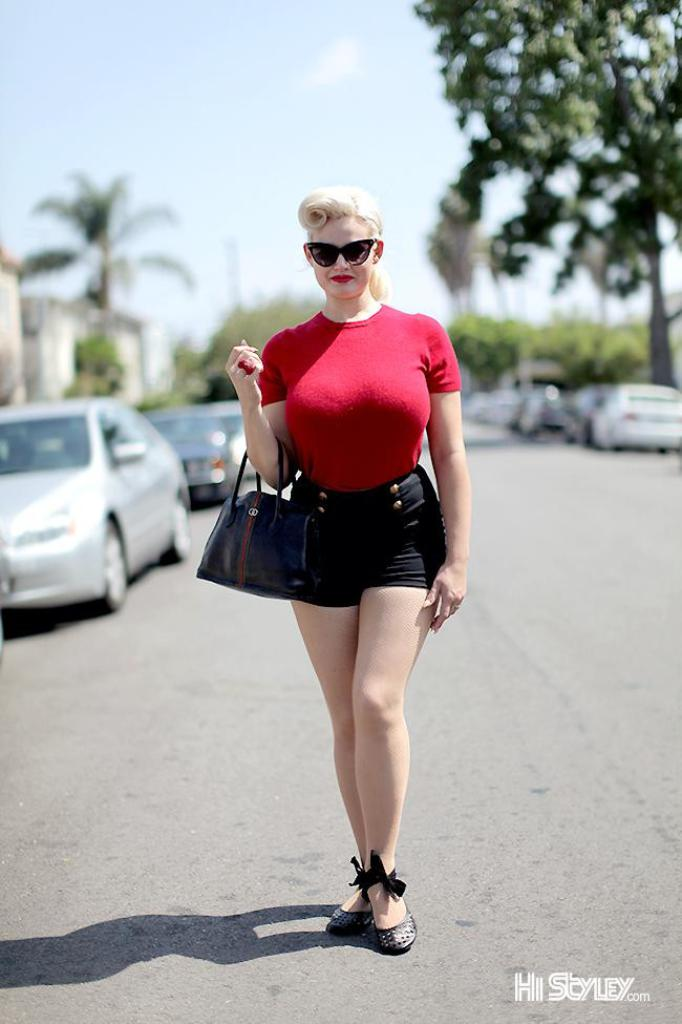



ID: 680
Distance: 1.465287685394287
Path: /Users/alucek/Documents/Jupyter_Notebooks/image_rag/fashion_dataset/image_710.png


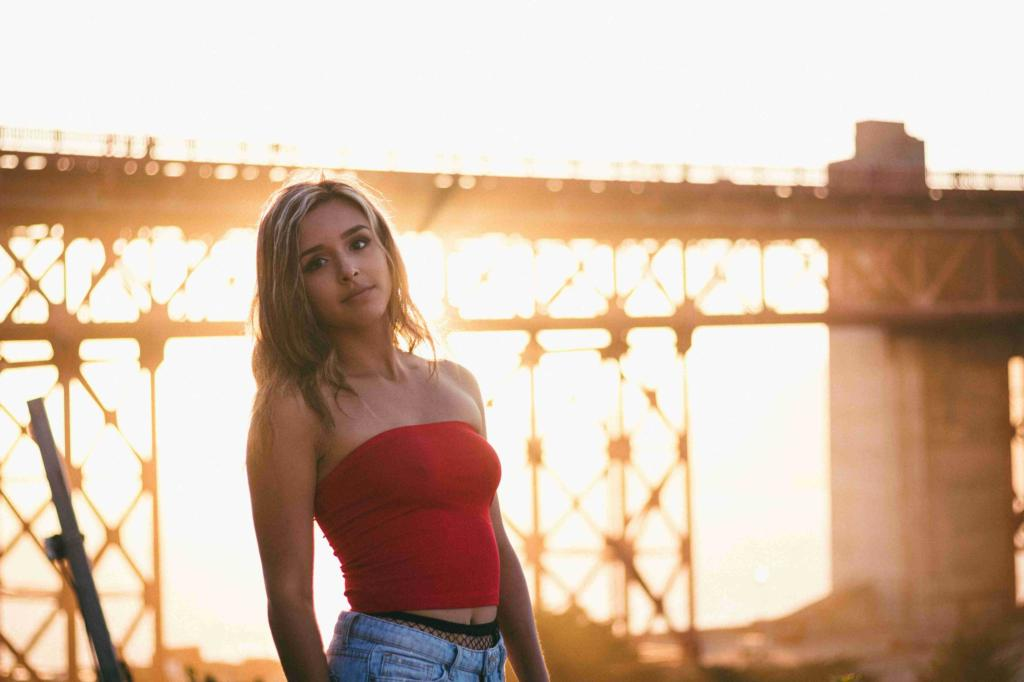



ID: 112
Distance: 1.466855764389038
Path: /Users/alucek/Documents/Jupyter_Notebooks/image_rag/fashion_dataset/image_2.png


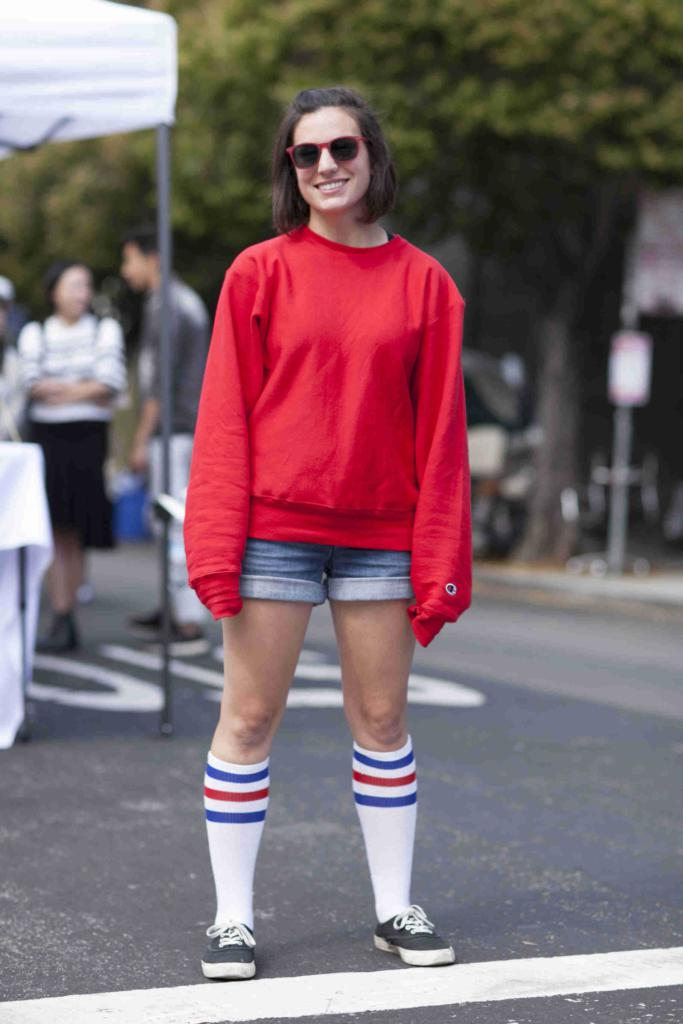



ID: 743
Distance: 1.472611904144287
Path: /Users/alucek/Documents/Jupyter_Notebooks/image_rag/fashion_dataset/image_768.png


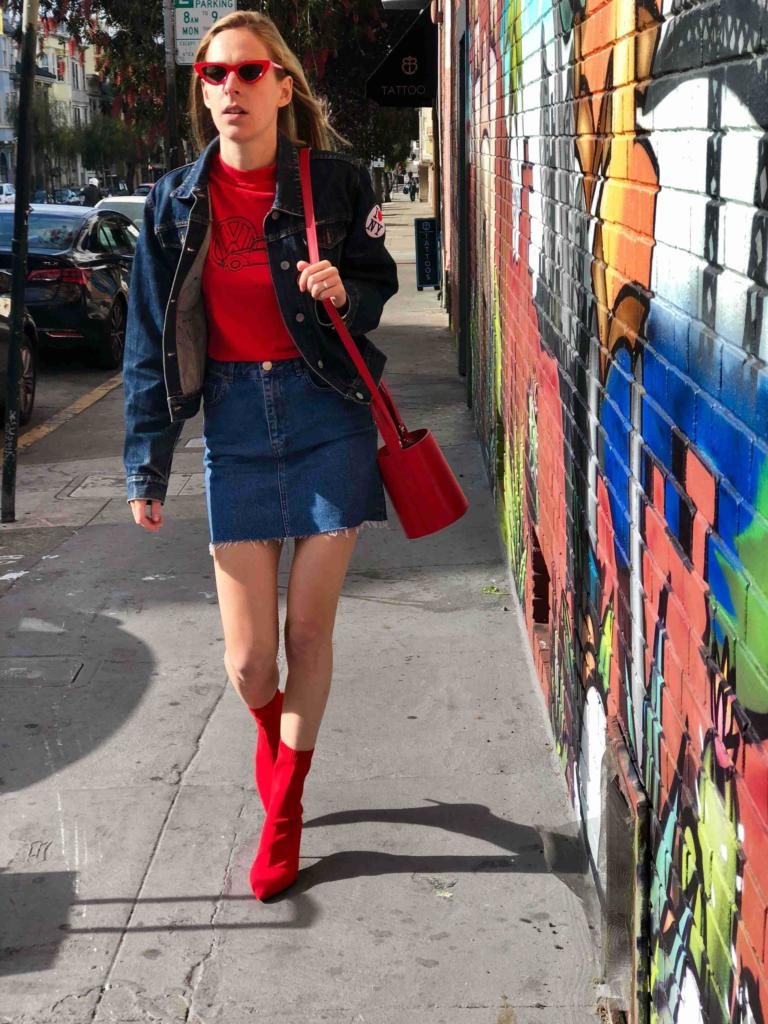



ID: 222
Distance: 1.484983205795288
Path: /Users/alucek/Documents/Jupyter_Notebooks/image_rag/fashion_dataset/image_299.png


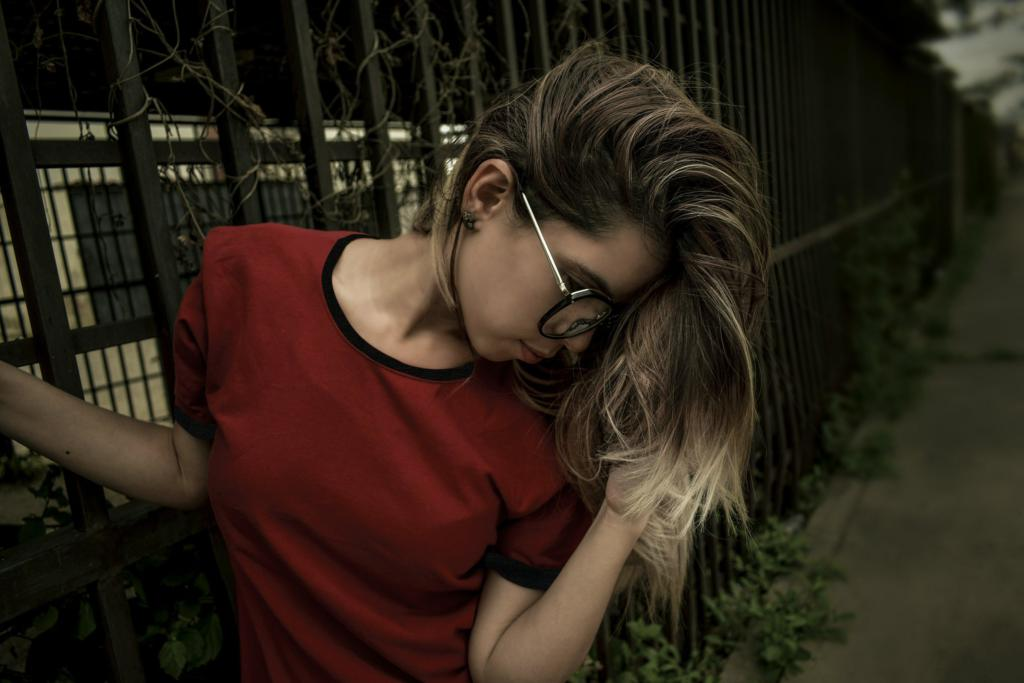

In [15]:
def query_db(query, results=5):
    results = image_vdb.query(
        query_texts=[query],
        n_results=results,
        include=['uris', 'distances'])
    return results

def print_results(results):
    for idx, uri in enumerate(results['uris'][0]):
        print(f"ID: {results['ids'][0][idx]}")
        print(f"Distance: {results['distances'][0][idx]}")
        print(f"Path: {uri}")
        display(Image(filename=uri, width=300))
        print("\n")

# Testing it out
query = 'red tops'
results = query_db(query)
print_results(results)

---
# Setting up the Retrieval Augmented Generation Flow

A Retrieval Augemented Generation flow or RAG flow tends to follow this order:
1. The user submits a text input (question, query, etc)
2. That input is then ran through the retrieval function first, where data is retrieved from the VectorDB.
     * In our case, we will try to pull images that match the user's input.
3. Those images, along with a prompt will be fed to a vision model, where it will use the images as context and respond to the prompt as a final output.

### Defining the LLM, Prompt, and LangChain Chain

For our vision model, we will be [using GPT-4o](https://openai.com/index/hello-gpt-4o/), OpenAI's latest model with vision capabilities at the time of creating this, along with the [LangChain framework](https://python.langchain.com/v0.2/docs/how_to/multimodal_prompts/) to set this flow up.

In [11]:
# Instantiate the LLM
gpt4o = ChatOpenAI(model="gpt-4o", temperature = 0.0)

# Instantiate the Output Parser
parser = StrOutputParser()

# Define the Prompt 
image_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful fashion and styling assistant. Answer the user's question  using the given image context with direct references to parts of the images provided."
                    " Maintain a more conversational tone, don't make too many lists. Use markdown formatting for highlights, emphasis, and structure."),
        (
            "user",
            [
                {"type": "text", "text": "What are some ideas for styling {user_query}"},
                {"type": "image_url", "image_url": "data:image/jpeg;base64,{image_data_1}"},
                {"type": "image_url", "image_url": "data:image/jpeg;base64,{image_data_2}"},
            ],
        ),
    ]
)

# Define the LangChain Chain
vision_chain = image_prompt | gpt4o | parser

### Formatting Query Results for LLM Prompting

To input the images in as context, we need to first encode them to [base64](https://en.wikipedia.org/wiki/Base64) for the LLM to be able to interpret it.

Base64 is a way of encoding data using only 64 different ASCII characters, which are safe to use in text-based systems. This encoding transforms binary data (like images or files) into a text format that can be easily transmitted and stored without corruption.

When you need to encode an image in Base64 for a vision model, it's usually because the model or the system hosting the model requires the image data in a text format. This ensures that the data is handled consistently across different platforms and languages. By encoding the image in Base64, you convert it into a string of text, making it easier to send and process without worrying about issues like data corruption or incompatibility with text-only systems.

The function below that will do that, and create a dictionary along with the original user query to pass into the chain. The chain will take a dictionary input, that will correspond to the three pieces of information that need to be injected into it `{user_query}`, `{image_data_1}`, `{image_data_2}`. 

In [12]:
def format_prompt_inputs(data, user_query):
    inputs = {}

    # Add user query to the dictionary
    inputs['user_query'] = user_query

    # Get the first two image paths from the 'uris' list
    image_path_1 = data['uris'][0][0]
    image_path_2 = data['uris'][0][1]
    
    # Encode the first image
    with open(image_path_1, 'rb') as image_file:
        image_data_1 = image_file.read()
    inputs['image_data_1'] = base64.b64encode(image_data_1).decode('utf-8')
    
    # Encode the second image
    with open(image_path_2, 'rb') as image_file:
        image_data_2 = image_file.read()
    inputs['image_data_2'] = base64.b64encode(image_data_2).decode('utf-8')
    
    return inputs

The output of this will look like this

```python
{
    "user_query": "What are some ideas for styling X"
    "image_data_1": Base64 Encoding of Image 1
    "image_data_2": Base64 Encoding of Image 2
}
```

And get passed to the prompt before all going to the language model

---
# Putting it All Together!

Now we have all of the pieces! Finally, we string these together, as well as display the retrieved photos to put it all together!

## FashionRAG is At Your Service!

What would you like to style today?


 brown pants


---

**Example Picture 1:**

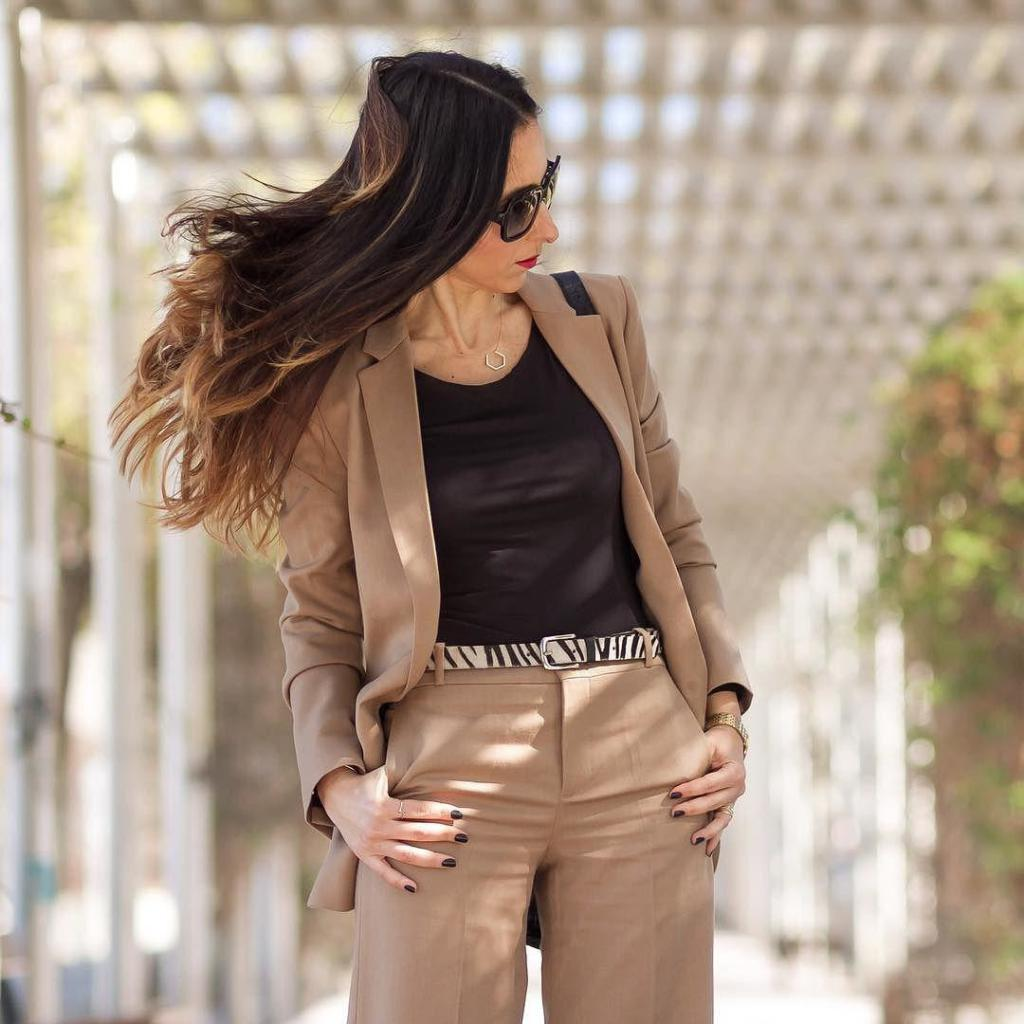

**Example Picture 2:**

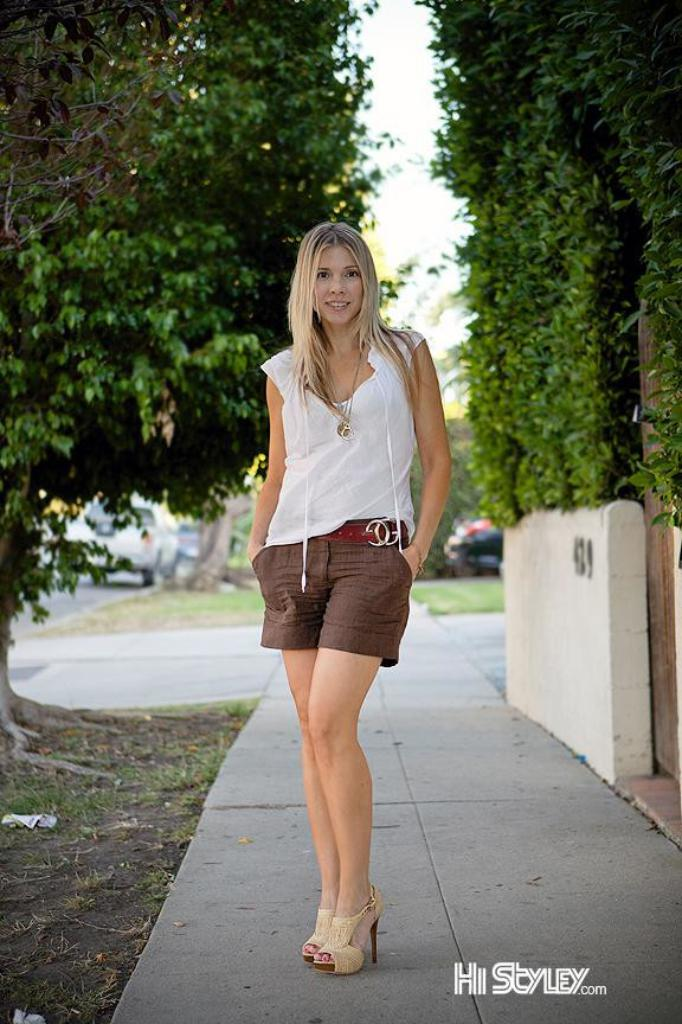

---

Styling brown pants can be quite versatile and chic! Here are some ideas inspired by the images you provided:

### 1. **Monochromatic Look**
In the first image, the brown pants are paired with a matching brown blazer and a black top. This creates a sophisticated and cohesive look. You can add a statement belt, like the zebra print one shown, to add some flair and break up the monotony.

- **Top:** Black or dark-colored top
- **Blazer:** Matching brown blazer
- **Accessories:** Statement belt, sunglasses, and minimal jewelry

### 2. **Casual Chic**
The second image shows a more casual approach with brown shorts paired with a white top. This is perfect for a relaxed, yet stylish look.

- **Top:** White or light-colored blouse or t-shirt
- **Shoes:** Neutral-toned heels or sandals
- **Accessories:** Simple jewelry and a stylish belt

### Additional Styling Tips:

- **Neutral Colors:** Brown pairs well with other neutral colors like white, black, beige, and cream. This creates a balanced and elegant look.
- **Pop of Color:** Add a pop of color with accessories like a bright scarf, handbag, or shoes to make the outfit more vibrant.
- **Layering:** For cooler weather, layer with a cozy sweater or a stylish coat. A denim jacket can also add a casual touch.
- **Patterns and Textures:** Don’t be afraid to mix in some patterns or textures. A striped or patterned top can add interest to the outfit.

### Footwear Options:
- **Heels:** For a more polished look, pair with heels or heeled boots.
- **Flats:** For a comfortable and casual vibe, opt for ballet flats or loafers.
- **Sneakers:** White sneakers can give a trendy and relaxed feel to the outfit.

### Accessories:
- **Belts:** A statement belt can add definition to your waist and elevate the look.
- **Jewelry:** Minimalist jewelry like a delicate necklace or small earrings can add a touch of elegance.
- **Bags:** A structured handbag or a crossbody bag can complete the look.

By mixing and matching these elements, you can create a variety of stylish outfits with brown pants!

In [17]:
display(Markdown("## FashionRAG is At Your Service!"))
display(Markdown("What would you like to style today?"))

query = input("\n")

# Running Retrieval and Generation
results = query_db(query, results=2)
prompt_input = format_prompt_inputs(results, query)
response = vision_chain.invoke(prompt_input)

display(Markdown("---"))
# Showing Retrieved Pictures
display(Markdown("**Example Picture 1:**"))
display(Image(filename=results['uris'][0][0], width=300))
display(Markdown("**Example Picture 2:**"))
display(Image(filename=results['uris'][0][1], width=300))

display(Markdown("---"))
# Printing LLM Response
display(Markdown(response))